### Aisya Mufidah Najwa, 1206230026

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [55]:
import kagglehub
import os
import matplotlib.pyplot as plt
from PIL import Image

# Step 1: Download dataset
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

# Step 2: Set directory paths
train_dir = os.path.join(path, 'seg_train', 'seg_train')
test_dir = os.path.join(path, 'seg_test', 'seg_test')

# Step 3: Identify classes in the dataset (subfolders in train_dir)
classes = os.listdir(train_dir)
print("Classes in the dataset:", classes)


Path to dataset files: C:\Users\najwa\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2
Classes in the dataset: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


transformasi pada gambar dan  visualisasi beberapa contoh gambar:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


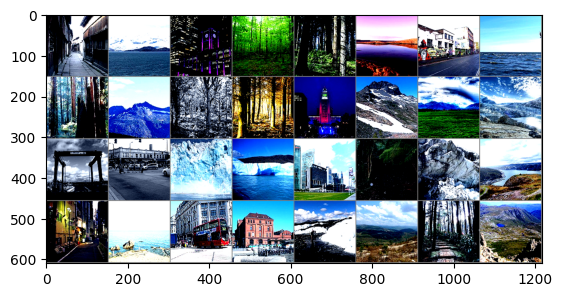

street glacier buildings forest


In [ ]:
# transformasi gambar
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Ukuran gambar standar
    transforms.ToTensor(),          # Mengubah gambar menjadi Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi
])

# Memuat dataset menggunakan ImageFolder
trainset = ImageFolder(root=train_dir, transform=transform)
testset = ImageFolder(root=test_dir, transform=transform)

# Membuat DataLoader
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Fungsi untuk menampilkan gambar beserta label kelasnya
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader) # ambil satu batch gambar dari DataLoader
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# print labelnya
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

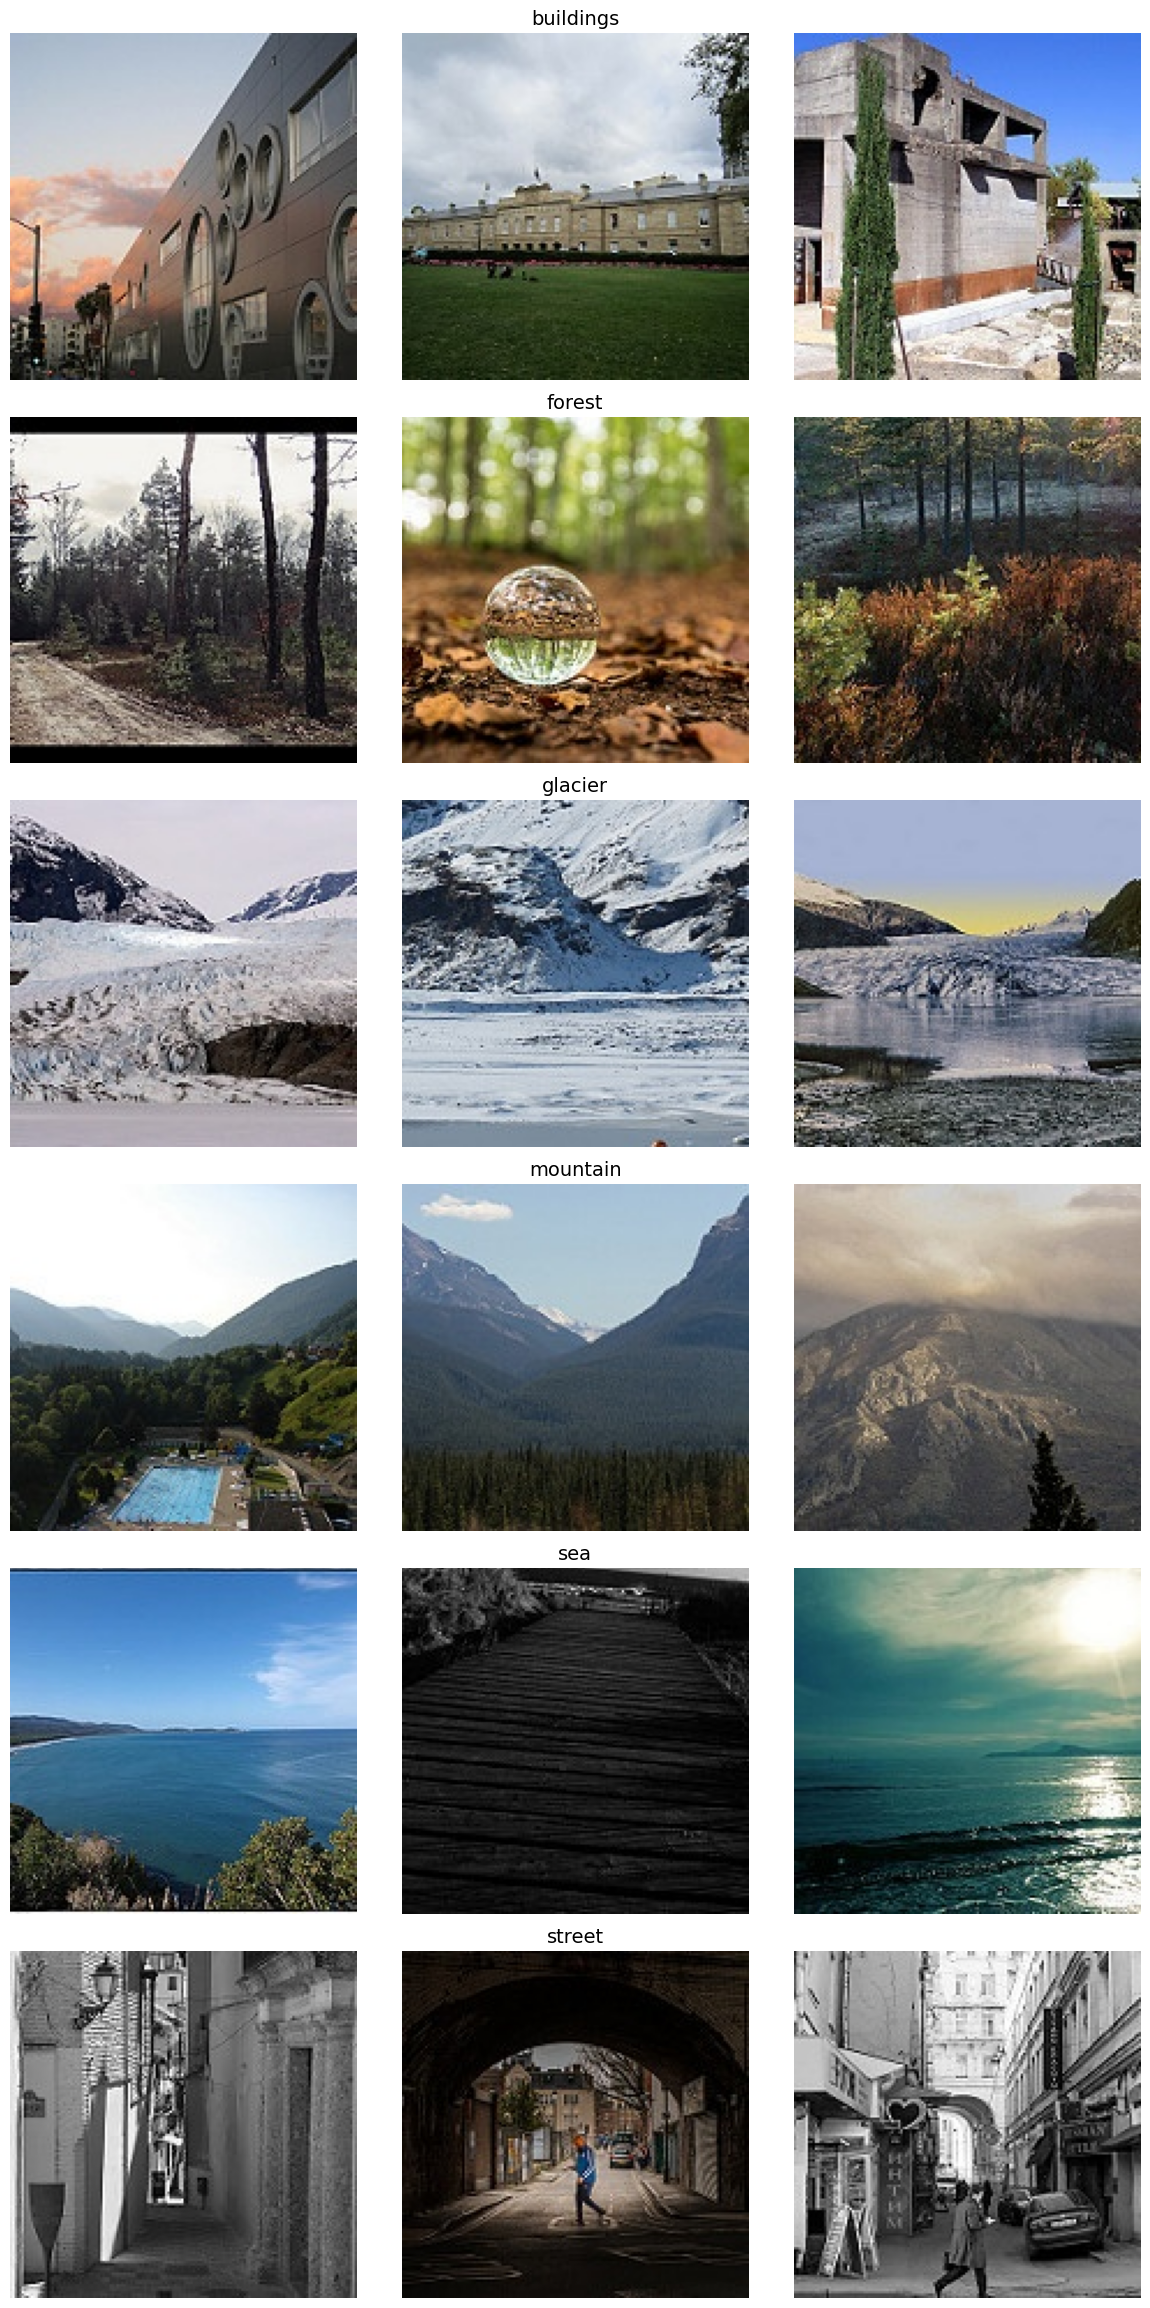

In [75]:
import random

def visualize_samples(classes, train_dir):
    # Menentukan jumlah gambar per kelas yang akan ditampilkan
    samples_per_class = 3
    fig, axes = plt.subplots(nrows=len(classes), ncols=samples_per_class, figsize=(12, 4 * len(classes)))

    for idx, cls in enumerate(classes):
        # Menentukan folder gambar untuk kelas ini
        cls_dir = os.path.join(train_dir, cls)
        # Mengambil daftar gambar dalam kelas ini dan memilih 3 gambar secara acak
        images = random.sample(os.listdir(cls_dir), samples_per_class)

        # Menampilkan gambar-gambar tersebut di subplot
        for j, img_file in enumerate(images):
            img_path = os.path.join(cls_dir, img_file)
            img = Image.open(img_path)
            axes[idx, j].imshow(img)
            axes[idx, j].axis('off')  # Matikan sumbu
            # Menambahkan label kelas pada gambar tengah per kelas
            if j == 1:
                axes[idx, j].set_title(cls, fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

visualize_samples(classes, train_dir)

In [57]:
print(f'total gambar dalam trainset: {len(trainset)}')
print(f'total gambar dalam testset: {len(testset)}')

total gambar dalam trainset: 14034
total gambar dalam testset: 3000


In [58]:
import torch.nn as nn
import torch.optim as optim

# Definisi Model CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Lapisan Convolutional 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling layer
        # Lapisan Convolutional 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Tambahkan AdaptiveAvgPool2d agar dapat menyesuaikan ukuran input secara dinamis
        self.pool2 = nn.AdaptiveAvgPool2d((8, 8))
        # Fully connected layer 1: Menghubungkan fitur ke neuron (64*8*8 ke 128)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        # Fully connected layer 2: Output 6 neuron (karena ada 6 kelas pada dataset)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # Aktivasi ReLU setelah konvolusi pertama
        x = self.pool(x)               # Max Pooling untuk mengurangi dimensi
        x = torch.relu(self.conv2(x))  # Aktivasi ReLU setelah konvolusi kedua
        x = self.pool(x)               # Max Pooling kedua
        x = self.pool2(x)              # Adaptive pooling ke ukuran tetap 8x8
        x = x.view(-1, 64 * 8 * 8)     # Flatten data menjadi vektor 1D
        x = torch.relu(self.fc1(x))    # Aktivasi ReLU pada fully connected pertama
        x = self.fc2(x)                # Fully connected kedua (output tanpa aktivasi)
        return x

In [59]:
model = CNNModel()  # Inisialisasi model
criterion = nn.CrossEntropyLoss()  # Loss untuk klasifikasi multi-kelas
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer Adam

In [60]:
# Training loop
for epoch in range(10):  # 10 epoch
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data  # Data input (gambar) dan label
        optimizer.zero_grad()  # Reset gradien
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Hitung loss
        loss.backward()  # Backward pass (hitung gradien)
        optimizer.step()  # Perbarui parameter

        running_loss += loss.item()
        if i % 100 == 99:  # Cetak setiap 100 batch
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

[Epoch 1, Batch 100] Loss: 1.095
[Epoch 1, Batch 200] Loss: 0.863
[Epoch 1, Batch 300] Loss: 0.734
[Epoch 1, Batch 400] Loss: 0.660
[Epoch 2, Batch 100] Loss: 0.605
[Epoch 2, Batch 200] Loss: 0.558
[Epoch 2, Batch 300] Loss: 0.529
[Epoch 2, Batch 400] Loss: 0.550
[Epoch 3, Batch 100] Loss: 0.467
[Epoch 3, Batch 200] Loss: 0.473
[Epoch 3, Batch 300] Loss: 0.490
[Epoch 3, Batch 400] Loss: 0.429
[Epoch 4, Batch 100] Loss: 0.413
[Epoch 4, Batch 200] Loss: 0.418
[Epoch 4, Batch 300] Loss: 0.395
[Epoch 4, Batch 400] Loss: 0.371
[Epoch 5, Batch 100] Loss: 0.362
[Epoch 5, Batch 200] Loss: 0.346
[Epoch 5, Batch 300] Loss: 0.355
[Epoch 5, Batch 400] Loss: 0.344
[Epoch 6, Batch 100] Loss: 0.298
[Epoch 6, Batch 200] Loss: 0.330
[Epoch 6, Batch 300] Loss: 0.308
[Epoch 6, Batch 400] Loss: 0.310
[Epoch 7, Batch 100] Loss: 0.254
[Epoch 7, Batch 200] Loss: 0.271
[Epoch 7, Batch 300] Loss: 0.269
[Epoch 7, Batch 400] Loss: 0.265
[Epoch 8, Batch 100] Loss: 0.234
[Epoch 8, Batch 200] Loss: 0.233
[Epoch 8, 

In [63]:
# Evaluasi model
correct = 0
total = 0
with torch.no_grad():  # Tidak perlu gradien saat evaluasi
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Ambil label prediksi
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f} %')

Accuracy: 84.97 %


In [62]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():  # Nonaktifkan perhitungan gradien saat evaluasi
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Ambil kelas dengan skor tertinggi
        c = (predicted == labels).squeeze()  # Bandingkan prediksi dan label sebenarnya
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()  # Tambahkan prediksi yang benar
            class_total[label] += 1  # Hitung total data per kelas

# Menghitung akurasi per kelas
for i, c in enumerate(classes):
    print(f'Accuracy of {c} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of buildings : 82.14 %
Accuracy of forest : 95.00 %
Accuracy of glacier : 77.94 %
Accuracy of mountain : 89.71 %
Accuracy of sea : 80.95 %
Accuracy of street : 93.44 %


### Arsitektur Model CNN

Model CNN ini terdiri dari beberapa lapisan yang memiliki fungsi masing-masing dalam mengekstraksi fitur dan melakukan klasifikasi.

1. **Lapisan Convolutional 1 (`conv1`)**:
   - Jumlah filter: 32
   - Ukuran filter: 3x3
   - Padding: 1 (untuk menjaga dimensi input dan output tetap sama)
   - Stride: 1 (untuk melangkah satu piksel pada setiap perhitungan konvolusi)
   - Fungsi: Mendeteksi fitur dasar gambar, seperti tepi dan tekstur.

2. **Max Pooling 1**:
   - Ukuran kernel: 2x2
   - Stride: 2
   - Fungsi: Mengurangi dimensi gambar dan mempercepat komputasi, sambil mempertahankan informasi penting.

3. **Lapisan Convolutional 2 (`conv2`)**:
   - Jumlah filter: 64
   - Ukuran filter: 3x3
   - Padding: 1
   - Stride: 1
   - Fungsi: Menangkap fitur yang lebih kompleks, seperti pola dan bentuk objek yang lebih besar.

4. **Max Pooling 2**:
   - Ukuran kernel: 2x2
   - Stride: 2
   - Fungsi: Mengurangi dimensi gambar lebih lanjut, menjaga informasi penting, dan mempercepat komputasi.

5. **Adaptive Average Pooling (`pool2`)**:
   - Output size: 8x8
   - Fungsi: Mengubah ukuran gambar secara otomatis menjadi 8x8 untuk memastikan dimensi input ke lapisan fully connected tetap konsisten, terlepas dari ukuran input asli.

6. **Fully Connected Layer 1 (`fc1`)**:
   - Jumlah neuron: 128
   - Fungsi: Menghubungkan fitur yang diekstraksi menjadi neuron untuk klasifikasi lebih lanjut.

7. **Fully Connected Layer 2 (`fc2`)**:
   - Jumlah neuron: 6
   - Fungsi: Menghasilkan output akhir yang terdiri dari 6 kelas untuk klasifikasi.

Model ini mengkombinasikan dua lapisan konvolusi untuk mengekstraksi fitur gambar, diikuti oleh lapisan pooling untuk mengurangi dimensi. Kemudian, lapisan fully connected digunakan untuk klasifikasi berdasarkan fitur yang diekstraksi. Model ini dioptimalkan untuk melakukan klasifikasi gambar ke dalam 6 kelas.

# Evaluasi Model CNN

### Akurasi Keseluruhan Model
- **Akurasi keseluruhan model** pada dataset pengujian adalah **84.97%**. Model sudah cukup baik dalam mengklasifikasikan gambar secara keseluruhan. Ada beberapa kelas yang masih bisa ditingkatkan performanya.

### Akurasi Per Kelas

- **Buildings**: 82.14%  
    Model menunjukkan akurasi yang cukup baik dalam mengenali gambar kategori "buildings".

- **Forest**: 95.00%  
    Akurasi pada kelas ini sangat baik, menunjukkan bahwa model mampu mengenali gambar kategori "forest" dengan presisi tinggi.

- **Glacier**: 77.94%  
    Akurasi pada kelas "glacier" cukup rendah jika dibandingkan dengan kelas lainnya. Ini menandakan bahwa model mungkin kesulitan membedakan gambar "glacier" dengan gambar dari kelas lain yang memiliki kesamaan visual.

- **Mountain**: 89.71%  
    Model bekerja cukup baik dalam mengklasifikasikan gambar kategori "mountain".
    
- **Sea**: 80.95%  
    Akurasi pada kelas "sea" juga masih bisa ditingkatkan, meskipun cukup baik, tetapi belum setinggi beberapa kelas lainnya.

- **Street**: 93.44%  
    Kelas ini menunjukkan hasil yang sangat baik dengan akurasi tinggi dalam mengenali gambar "street".

In [66]:
from collections import Counter

# Hitung jumlah gambar untuk setiap kelas di trainloader
class_counts = Counter()

for _, labels in trainloader:
    class_counts.update(labels.numpy())  # update dengan label gambar dalam batch

# Tampilkan jumlah gambar per kelas
for i, class_name in enumerate(classes):
    print(f'Jumlah gambar untuk kelas {class_name}: {class_counts[i]}')


Jumlah gambar untuk kelas buildings: 2191
Jumlah gambar untuk kelas forest: 2271
Jumlah gambar untuk kelas glacier: 2404
Jumlah gambar untuk kelas mountain: 2512
Jumlah gambar untuk kelas sea: 2274
Jumlah gambar untuk kelas street: 2382


Kelas dengan akurasi rendah:

Glacier (77.94%) dan Sea (80.95%) memiliki akurasi yang lebih rendah dibandingkan kelas lainnya. Ini menunjukkan bahwa model kesulitan membedakan antara gambar-gambar yang termasuk dalam kelas Glacier dan Sea dengan gambar-gambar dari kelas lain.

### Rekomendasi Perbaikan

#### 1. Augmentasi Data
Meskipun dataset seimbang, augmentasi data dapat membantu memperkenalkan variasi baru pada gambar, seperti rotasi, flipping, zooming, dan perubahan pencahayaan. Bisa membantu model mengenali lebih banyak variasi dalam gambar dan meningkatkan generalisasi model.

#### 2. Tuning Hyperparameter
Mencoba berbagai setting hyperparameter, seperti learning rate, batch size, atau jumlah layer konvolusional, bisa meningkatkan performa model. Kadang, setting yang tepat dapat membuat model lebih sensitif terhadap fitur-fitur yang membedakan antar kelas.

#### 3. Peningkatan Preprocessing
Menambah preprocessing lainnya, seperti pengurangan noise atau teknik edge detection, dapat membantu model dalam mengenali fitur yang lebih baik.
